<a href="https://colab.research.google.com/github/IA2122/practica-8-paochoa/blob/main/practica8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 8. Visión por computador II

En esta práctica vamos a crear un clasificador capaz de reconocer dígitos manuscritos, para ello utilizaremos el dataset [MNIST](http://yann.lecun.com/exdb/mnist/) que ya hemos utilizado en prácticas anteriores.

Recordad los 5 pasos de un clasificador de imágenes:
1. Preparar el dataset.
2. Separar en conjuntos de entrenamiento, test y validación.
3. Extraer descriptores.
4. Entrenar el modelo.
5. Evaluar el modelo.

En muchas ocasiones los pasos 2 y 3 son intercambiables, y es lo que haremos en esta práctica.

## 0. Carga del dataset y descripción de las imágenes
 
Para cargar el dataset y describir las imágenes vamos a utilizar las clases `CargaYDescribe` (definida en el fichero CargaYDescribe.py de la carpeta p10) y la clase `Descriptor` junto con sus hijas (definidas en el fichero Descriptor.py también dentro de la carpeta p10). Deberás descargar esta carpeta y descomprimirla utilizando el siguiente comando. 



In [1]:
!wget www.unirioja.es/cu/joheras/ia/p10/p10.zip -O p10.zip
!unzip p10.zip

--2022-05-10 15:12:40--  http://www.unirioja.es/cu/joheras/ia/p10/p10.zip
Resolving www.unirioja.es (www.unirioja.es)... 193.144.2.30
Connecting to www.unirioja.es (www.unirioja.es)|193.144.2.30|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.unirioja.es/cu/joheras/ia/p10/p10.zip [following]
--2022-05-10 15:12:41--  https://www.unirioja.es/cu/joheras/ia/p10/p10.zip
Connecting to www.unirioja.es (www.unirioja.es)|193.144.2.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1274 (1.2K) [application/zip]
Saving to: ‘p10.zip’

p10.zip             100%[===================>]   1.24K  --.-KB/s    in 0s      

2022-05-10 15:12:41 (64.4 MB/s) - ‘p10.zip’ saved [1274/1274]

Archive:  p10.zip
   creating: p10/
  inflating: p10/CargaYDescribe.py   
  inflating: p10/Descriptor.py       
  inflating: p10/__init__.py         


Si abres el fichero Descriptor.py (puedes abrir dicho fichero pulsando en la pestaña con el símbolo ">" que aparece a la izquierda de la pantalla y luego pulsando en la pestaña Files), verás la definición de la clase `Descriptor` y de dos clases hijas. La principal característica de la clase `Descriptor` es que tiene un método llamado `describe` que sirve para describir una imagen. Este método es abstracto y lo proporcionan las clases hijas.

##### Pregunta

¿Qué hacen los métodos ``describe`` de las clases RawImage y Projection?

In [2]:
#Respuesta. 

# El describe de RawImage pasa una imagen a color a escala de grises y la convierte en una array 1-D

# El describe de Projection pasa una imagen a color a escala de grises 
#   y luego calcula la suma de cada fila y de cada columna y las almacena en data

Si ahora abres el fichero CargaYDescribe.py verás la definición de la clase `CargaYDescribe`. Esta clase permite cargar y describir las imágenes de un directorio que está organizado mediante carpetas donde cada carpeta contiene
las imágenes de una clase.

El constructor de esta clase recibe dos parámetros, un objeto de la clase `Descriptor`, lo que nos permite cambiar fácilmente el método que usamos para describir las imágenes (esta es una técnica llamada inyección de dependencias que ya hemos utilizado alguna vez), y un path que es donde se encuentran las carpetas con las imágenes de cada clase.

Definimos una variable donde almacenamos el path donde se encuentran nuestra imágenes. De nuevo, es necesario descargar la carpeta.

In [3]:
%%capture
!wget www.unirioja.es/cu/joheras/ia/p10/digitos.zip
!unzip digitos.zip

In [4]:
dataset = "digitos/"

Para este ejemplo vamos a utilizar como descriptor el RawImage. 

In [5]:
from p10.Descriptor import *
from p10.CargaYDescribe import *

descriptor = RawImage()
cargaDatos = CargaYDescribe(dataset,descriptor)
(datos,etiquetas) = cargaDatos.cargaYdescribe()

##### Ejercicio

Comprueba que puedes cambiar de descriptor y que todo sigue funcionando correctamente.


In [6]:
descriptorP = Projection()
(datosP, etiquetasP) = CargaYDescribe(dataset, descriptorP).cargaYdescribe()

## 1. Separando el conjunto de entrenamiento y el de test

##### Ejercicio

Utiliza la función train_test_split, vista en las prácticas de aprendizaje automático, para partir el dataset en la siguiente proporción: 75% entrenamiento, 25% test. Almacena la partición en las variables:
`trainData`, `testData`, `trainLabels`, `testLabels`. Utiliza como random_state el valor 84 para así obtener siempre los mismos resultados.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [8]:
(trainData, testData, trainLabels, testLabels) = train_test_split(datos,etiquetas,test_size=0.25, random_state=84)
scores = ['precision']

In [9]:
def gridsearch(model,parameters,scores,k):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, parameters, cv=k,
                           scoring='%s_macro' % score)
        clf.fit(trainData, trainLabels)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

## 2. Entrenando el modelo

Una vez que hemos partido el banco de imágenes, podemos entrenar distintos modelos como vimos en prácticas anteriores. 

**Ejercicio** 

Utiliza KNN y aplica validación cruzada para fijar los hiperparámetros.

Tanto GridSearch como RandomSearch aplican internamente validación cruzada

In [10]:
modelKNN = KNeighborsClassifier()
tuned_parametersKNN = [{'n_neighbors': [2,3,4,5,6,7,8,9]}]
gridsearch(modelKNN,tuned_parametersKNN,scores,5)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:

0.891 (+/-0.021) for {'n_neighbors': 2}
0.903 (+/-0.028) for {'n_neighbors': 3}
0.904 (+/-0.030) for {'n_neighbors': 4}
0.899 (+/-0.016) for {'n_neighbors': 5}
0.900 (+/-0.020) for {'n_neighbors': 6}
0.896 (+/-0.021) for {'n_neighbors': 7}
0.898 (+/-0.027) for {'n_neighbors': 8}
0.896 (+/-0.031) for {'n_neighbors': 9}



**Ejercicio** 

Una vez hayas encontrado los mejores hiperparámetros almacena y entrena el modelo.

In [11]:
modelKNNbest = KNeighborsClassifier(n_neighbors=3)
modelKNNbest.fit(trainData, trainLabels)
predKNNbest = modelKNNbest.predict(testData)

##### Ejercicio

Utiliza otro de los algoritmos de clasificación vistos en las prácticas anteriores para crear un nuevo modelo.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

def randomsearch(model,parameters,scores,k=5):
    for score in scores:  
      print("# Tuning hyper-parameters for %s" % score)
      print()

      clf = RandomizedSearchCV(model, parameters,cv=k)
      clf.fit(trainData, trainLabels)

      print("Best parameters set found on development set:")
      print()
      print(clf.best_params_)
      print()

In [13]:
modelMultiLayerPerceptron = MLPClassifier(max_iter=600)
randomsearch(modelMultiLayerPerceptron, {'hidden_layer_sizes': [(5,5), (10,3,3), (6,3,2), (8,4,3,2)],
                                         'activation':['identity', 'tanh', 'relu'],
                                         'learning_rate_init': [0.001, 0.01, 0.1],
                                         'momentum': [0.9, 0.95, 0.99]},scores,5)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'momentum': 0.9, 'learning_rate_init': 0.1, 'hidden_layer_sizes': (10, 3, 3), 'activation': 'identity'}



In [14]:
modelMLPbest = MLPClassifier(momentum = 0.9, learning_rate_init = 0.01, hidden_layer_sizes = (10, 3, 3), activation = "tanh", max_iter = 600)
modelMLPbest.fit(trainData, trainLabels)
predMLPbest = modelMLPbest.predict(testData)

## 3. Evaluando el modelo

##### Ejercicio
Una vez tienes tu modelo construido evalualo utilizando la función `classification_report` de la librería sklearn.

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [16]:
print(classification_report(testLabels, predKNNbest))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        71
           1       0.91      1.00      0.95        74
           2       0.95      0.86      0.90        66
           3       0.74      0.93      0.82        42
           4       0.89      0.89      0.89        66
           5       0.89      0.86      0.88        58
           6       0.99      0.99      0.99        70
           7       0.97      0.97      0.97        58
           8       1.00      0.74      0.85        69
           9       0.82      0.85      0.84        66

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.90       640
weighted avg       0.91      0.91      0.91       640



In [17]:
print(classification_report(testLabels, predMLPbest, zero_division = 0))

              precision    recall  f1-score   support

           0       0.25      0.99      0.40        71
           1       0.33      0.96      0.49        74
           2       0.00      0.00      0.00        66
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        58
           6       0.00      0.00      0.00        70
           7       0.34      0.84      0.49        58
           8       0.00      0.00      0.00        69
           9       0.00      0.00      0.00        66

    accuracy                           0.30       640
   macro avg       0.09      0.28      0.14       640
weighted avg       0.10      0.30      0.14       640



##### Ejercicio 

A continuación muestra la matriz de confusión para ver dónde se producen los fallos. 

In [18]:
print(confusion_matrix(testLabels, predKNNbest))

[[70  0  0  0  0  0  1  0  0  0]
 [ 0 74  0  0  0  0  0  0  0  0]
 [ 2  1 57  4  1  0  0  0  0  1]
 [ 0  0  0 39  0  2  0  0  0  1]
 [ 1  1  0  0 59  0  0  0  0  5]
 [ 0  2  1  3  0 50  0  0  0  2]
 [ 1  0  0  0  0  0 69  0  0  0]
 [ 0  0  1  0  0  0  0 56  0  1]
 [ 1  2  1  7  2  2  0  1 51  2]
 [ 2  1  0  0  4  2  0  1  0 56]]


In [19]:
print(confusion_matrix(testLabels, predMLPbest))

[[70  1  0  0  0  0  0  0  0  0]
 [ 3 71  0  0  0  0  0  0  0  0]
 [21 44  0  1  0  0  0  0  0  0]
 [11 31  0  0  0  0  0  0  0  0]
 [26  0  0  0  0  0  0 40  0  0]
 [40 15  0  0  0  0  0  3  0  0]
 [42 28  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0 49  0  0]
 [43 25  0  0  0  0  0  1  0  0]
 [14  1  0  0  0  0  0 51  0  0]]


##### Ejercicio

Con el modelo KNN somos capaces de conseguir una precisión del 92%, aunque no está mal, se puede mejorar. Intenta construir un modelo que mejore estos resultados, puedes probar también a cambiar de descriptor.

In [20]:
(trainDataP, testDataP, trainLabelsP, testLabelsP) = train_test_split(datosP, etiquetasP, test_size=0.25, random_state=84)

In [21]:
modelKNNP = KNeighborsClassifier(n_neighbors=3)
modelKNNP.fit(trainDataP, trainLabelsP)
predKNNP = modelKNNP.predict(testDataP)

In [22]:
print(classification_report(testLabelsP, predKNNP))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        71
           1       0.68      0.97      0.80        74
           2       0.89      0.76      0.82        66
           3       0.62      0.74      0.67        42
           4       0.79      0.74      0.77        66
           5       0.78      0.48      0.60        58
           6       0.93      0.89      0.91        70
           7       0.93      0.90      0.91        58
           8       0.89      0.68      0.77        69
           9       0.76      0.77      0.77        66

    accuracy                           0.80       640
   macro avg       0.80      0.79      0.79       640
weighted avg       0.81      0.80      0.79       640



In [23]:
def gridsearchP(model,parameters,scores,k):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, parameters, cv=k,
                           scoring='%s_macro' % score)
        clf.fit(trainDataP, trainLabelsP)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

In [24]:
modeloKNN = KNeighborsClassifier()
gridsearchP(modeloKNN,tuned_parametersKNN,scores,5)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:

0.753 (+/-0.057) for {'n_neighbors': 2}
0.761 (+/-0.039) for {'n_neighbors': 3}
0.766 (+/-0.033) for {'n_neighbors': 4}
0.778 (+/-0.030) for {'n_neighbors': 5}
0.764 (+/-0.036) for {'n_neighbors': 6}
0.771 (+/-0.026) for {'n_neighbors': 7}
0.775 (+/-0.030) for {'n_neighbors': 8}
0.771 (+/-0.028) for {'n_neighbors': 9}



In [25]:
modelKNNP2 = KNeighborsClassifier(n_neighbors = 5, algorithm = "kd_tree")
modelKNNP2.fit(trainDataP, trainLabelsP)
predKNNP2 = modelKNNP2.predict(testDataP)

In [26]:
print(classification_report(testLabelsP, predKNNP2))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87        71
           1       0.69      0.96      0.80        74
           2       0.87      0.80      0.83        66
           3       0.70      0.76      0.73        42
           4       0.87      0.73      0.79        66
           5       0.83      0.50      0.62        58
           6       0.93      0.91      0.92        70
           7       0.96      0.93      0.95        58
           8       0.82      0.68      0.75        69
           9       0.75      0.80      0.77        66

    accuracy                           0.81       640
   macro avg       0.82      0.81      0.80       640
weighted avg       0.82      0.81      0.81       640



## 4. Guardando y cargando el modelo

El proceso de entrenar un modelo puede ser muy costoso, por lo que conviene guardar el modelo para poder recuperarlo posteriormente. Para ello utilizamos la librería `pickle`.

In [27]:
import pickle

La siguiente instrucción guarda el modelo en el fichero modelo.sav.

In [28]:
pickle.dump(modelKNNP, open('modelo.sav', 'wb'))

La siguiente instrucción carga el modelo del fichero modelo.sav.

In [29]:
loaded_model = pickle.load(open('modelo.sav', 'rb'))

Ahora podemos usar el modelo igual que antes.

In [30]:
predictions = loaded_model.predict(testDataP)
print(classification_report(testLabelsP, predictions))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        71
           1       0.68      0.97      0.80        74
           2       0.89      0.76      0.82        66
           3       0.62      0.74      0.67        42
           4       0.79      0.74      0.77        66
           5       0.78      0.48      0.60        58
           6       0.93      0.89      0.91        70
           7       0.93      0.90      0.91        58
           8       0.89      0.68      0.77        69
           9       0.76      0.77      0.77        66

    accuracy                           0.80       640
   macro avg       0.80      0.79      0.79       640
weighted avg       0.81      0.80      0.79       640



Para descargar el fichero desde Colab a nuestro ordenador, hay que ejecutar las siguientes instrucciones (esta funcionalidad solo está disponible usando como navegador Google Chrome).

In [31]:
from google.colab import files
files.download('modelo.sav') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Ejercicio

Guarda tu mejor modelo en el fichero `mimodelo.sav`.

In [32]:
pickle.dump(modelKNNbest, open('modelo.sav', 'wb'))

###### Ejercicio

Realizar un estudio estadístico utilizando el paquete StatisticalAnalisis visto en la práctica 6. 


In [33]:
!pip install StatisticalAnalysis

  Created wheel for StatisticalAnalysis: filename=StatisticalAnalysis-0.0.5-py2.py3-none-any.whl size=13122 sha256=cce89cbe701e3824a6b70862113786b779ef045c81845f3bf9f6f4c29b92ab6d
  Stored in directory: /root/.cache/pip/wheels/37/d7/b4/16b0207c2fe82f25f64c17e61c8c2027aea5fad65d059c2394
Successfully built StatisticalAnalysis


In [34]:
from StatisticalAnalysis import compare_methods
from tensorflow.keras.utils import to_categorical

In [35]:
# Árbol de decisión
clfTree = DecisionTreeClassifier(random_state=84)
param_distTree = {"min_samples_split": sp_randint(3, 30)}
# SVM
clfSVC = SVC(random_state=84)
param_distSVC = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],'kernel': ['rbf'], 'class_weight':['balanced', None]}
# KNN
clfKNN = KNeighborsClassifier()
param_distKNN = {'n_neighbors':sp_randint(3, 30)}
# Regresión logística
clfLR = LogisticRegression(random_state=84)
param_distLR = {'C': [0.1,0.5,1, 10, 100, 1000]}
# Red neuronal
clfMLP = MLPClassifier(random_state=84, max_iter=600)
param_distMLP = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                 'alpha': sp_randint(0.0001, 1), 'learning_rate': ['constant', 'invscaling', 'adaptive'],
                 'hidden_layer_sizes': [(5,2), (3,3,3), (5,3,2), (5,4,3,2)],
                 'momentum': [0.9, 0.95, 0.99]}

In [36]:
listAlgorithms = [clfTree,clfKNN]

In [37]:
listParams = [param_distTree,param_distKNN]

In [38]:
listNames = ["Arbol", "KNN"]

In [39]:
datos = np.array(datos)
etiquetas = to_categorical(etiquetas)

In [40]:
(trainData, testData, trainLabels, testLabels) = train_test_split(datos,etiquetas,test_size=0.25, random_state=84)

temp.csv
['Arbol' 'KNN']
Report
**********************************************************
Mean and std
**********************************************************
Arbol: 0.827910 (0.016724)
KNN: 0.951273 (0.008375)
**********************************************************
Statistical tests
**********************************************************
----------------------------------------------------------
Checking parametric conditions 
----------------------------------------------------------
Checking independence 
Ok
Checking normality using Shapiro-Wilk's test for normality, alpha=0.05
W: 0.796595, p:0.000769
The null hypothesis (normality) is rejected
Checking heteroscedasticity using Levene's test, alpha=0.05
W: 5.479624, p:0.030952
The null hypothesis (heteroscedasticity) is rejected
Conditions for a parametric test are not fulfilled, applying a non-parametric test
----------------------------------------------------------
Working with 2 algorithms
-----------------------------

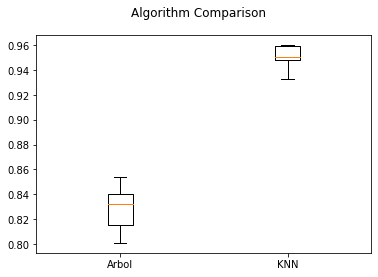

In [42]:
compare_methods(datos, etiquetas, listAlgorithms, listParams, listNames, metric='auroc')

##### Ejercicio

En la práctica 5 se proporcionó un fichero que explicaba cómo utilizar la librería `keras` para construir un modelo capaz de predecir los dígitos manuscritos. Utiliza dicha funcionalidad para construir un modelo de predicción. 

In [43]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512,activation='relu',input_shape=(28*28,)))
network.add(layers.Dense(10,activation='softmax'))
network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [113]:
network.fit(trainData,trainLabels,epochs=15,batch_size=128)

Epoch 1/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/15
15/15 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/15
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+0

In [114]:
test_loss,test_acc = network.evaluate(testData,testLabels)
print('test_acc:', test_acc)

20/20 [==============================] - 0s 3ms/step - loss: 6.9376 - accuracy: 0.9172
test_acc: 0.917187511920929


##### Ejercicio

El último ejercicio adicional que se propone consiste en combinar la funcionalidad de contornos vista en la práctica 7 y el clasificador de identificación de dígitos. 

Comenzamos cargando las librerías y funcionalidades necesarias. 

In [46]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
%matplotlib inline 

In [47]:
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

Cargamos la imagen en la cual queremos leer los dígitos escritos y la mostramos.

URL transformed to HTTPS due to an HSTS policy
--2022-05-10 15:34:45--  https://www.unirioja.es/cu/joheras/ia/p10/imagen1.png
Resolving www.unirioja.es (www.unirioja.es)... 193.144.2.30
Connecting to www.unirioja.es (www.unirioja.es)|193.144.2.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318579 (311K) [image/png]
Saving to: ‘imagen1.png’

imagen1.png         100%[===================>] 311.11K  --.-KB/s    in 0.1s    

2022-05-10 15:34:46 (2.61 MB/s) - ‘imagen1.png’ saved [318579/318579]



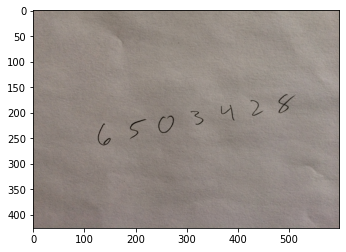

In [48]:
!wget www.unirioja.es/cu/joheras/ia/p10/imagen1.png
image = cv2.imread("imagen1.png")
mostrarImagen(image)

Convierte la imagen a escala de grises.

In [49]:
gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Aplica una umbralización con valor de umbral 80.

In [50]:
umbral = cv2.threshold(gris, 80, 255, cv2.THRESH_BINARY_INV)[1]

Busca los cortornos de la imagen, y para cada uno de ellos encuentra el bounding box que lo contiene. 

In [51]:
def sort_contours(cnts):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:(b[1][1],b[1][0]), reverse=False))
    return cnts

Contorno #1 -- solidity=0.33 -- area=224.50 -- aspectRatio=0.83 -- extent=0.21 -- hullArea=671.50


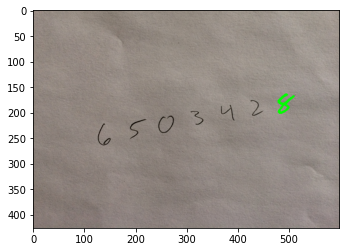

Contorno #2 -- solidity=0.06 -- area=25.00 -- aspectRatio=0.77 -- extent=0.04 -- hullArea=430.00


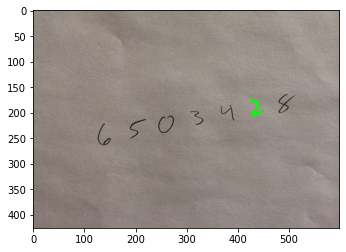

Contorno #3 -- solidity=0.97 -- area=129.00 -- aspectRatio=1.12 -- extent=0.45 -- hullArea=133.50


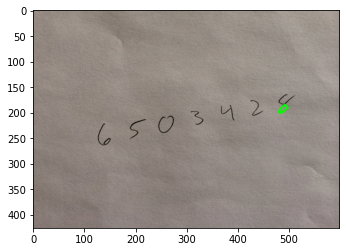

Contorno #4 -- solidity=0.07 -- area=30.50 -- aspectRatio=0.87 -- extent=0.04 -- hullArea=451.50


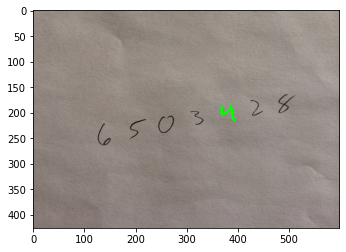

Contorno #5 -- solidity=0.07 -- area=27.00 -- aspectRatio=0.96 -- extent=0.04 -- hullArea=371.00


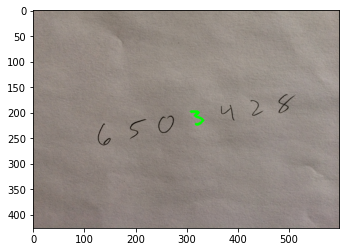

Contorno #6 -- solidity=0.12 -- area=91.00 -- aspectRatio=0.89 -- extent=0.08 -- hullArea=748.00


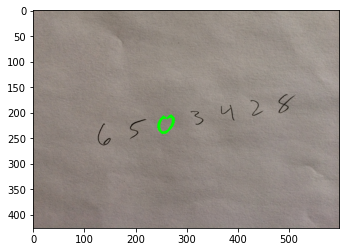

Contorno #7 -- solidity=0.13 -- area=75.50 -- aspectRatio=0.84 -- extent=0.06 -- hullArea=586.50


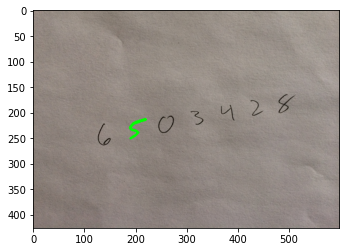

Contorno #8 -- solidity=0.19 -- area=126.50 -- aspectRatio=0.58 -- extent=0.12 -- hullArea=658.50


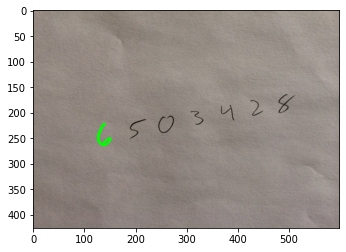

Contorno #9 -- solidity=0.92 -- area=52.00 -- aspectRatio=1.00 -- extent=0.36 -- hullArea=56.50


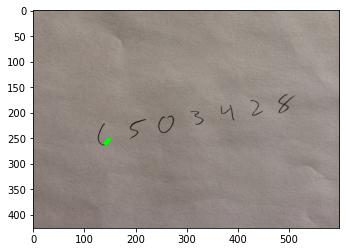

In [52]:
contornos, _ = cv2.findContours(umbral.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts_sorted = sort_contours(contornos)
clon = image.copy()
for (i, c) in enumerate(cnts_sorted):
  area = cv2.contourArea(c)
  (x, y, w, h) = cv2.boundingRect(c)
  aspectRatio = w / float(h)
  extent = area / float(w * h)
  hull = cv2.convexHull(c)
  hullArea = cv2.contourArea(hull)
  solidity = area / float(hullArea)
 
  # Visualizamos cada contorno y el convex hull asociado al mismo
  cv2.drawContours(clon, [c], -1, (240, 0, 159), 3)
  print("Contorno #{} -- solidity={:.2f} -- area={:.2f} -- aspectRatio={:.2f} -- extent={:.2f} -- hullArea={:.2f}".
        format(i + 1, solidity,area,aspectRatio,extent,hullArea))
  clon = image.copy()
  cv2.drawContours(clon, [c], -1, (0, 255, 0), 3)
  mostrarImagen(clon)

Utilizando el bounding box que contiene al contorno, predice el número contenido utilizando el modelo que hayas definido y muestra el resultado en la imagen. Debes tener en cuenta varias cosas, las imágenes del dataset tienen tamaño 28x28, por lo que es posible que tengas que reescalar tu imagen, además en las imágenes el digito aparece en blanco con fondo negro, mientras que en la imagen está justo al revés, por lo que tendrás que invertir los colores. 

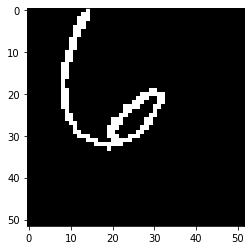

2

In [105]:
(x, y, w, h) = cv2.boundingRect(cnts_sorted[8])
mostrarImagen(umbral[y-20:y+h+20, x-20:x+w+20])
img = cv2.resize(umbral[y-10:y+h+10, x-10:x+w+10], (28,28)).reshape(1, 784)
np.argmax(network.predict(img))

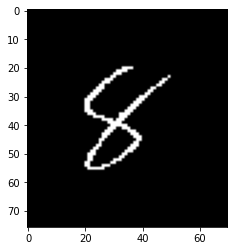

8


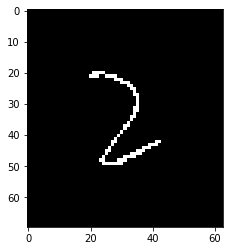

2


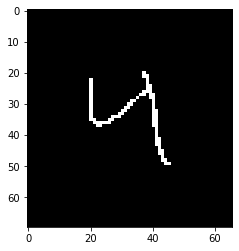

4


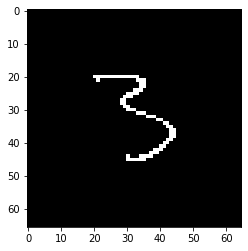

3


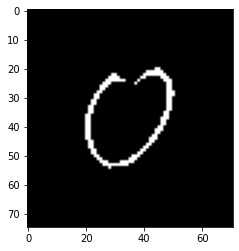

5


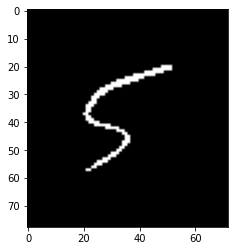

5


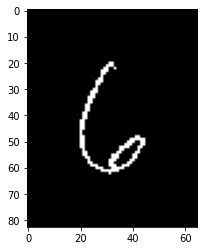

5


In [110]:
clon = image.copy()
for (i, c) in enumerate(cnts_sorted):
  area = cv2.contourArea(c)
  (x, y, w, h) = cv2.boundingRect(c)
  aspectRatio = w / float(h)
  extent = area / float(w * h)
  hull = cv2.convexHull(c)
  hullArea = cv2.contourArea(hull)
  solidity = area / float(hullArea)
  if solidity < 0.5:
    mostrarImagen(umbral[y-20:y+h+20, x-20:x+w+20])
    img = cv2.resize(umbral[y-9:y+h+9, x-9:x+w+9], (28,28)).reshape(1, 784)
    print(np.argmax(network.predict(img)))

Guarda este fichero con tus soluciones a los distintos ejercicios usando la opción **"Save in Github..."**. 